In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import math
import os
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from timeit import default_timer as timer


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places

# set random see for reproducibility
RANDOM_SEED = 10


np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

# Data cleaning

In [2]:
power=pd.read_csv('data/THPOE_POWER export 2019-08-14.csv')
power=pd.DataFrame(power)
power['TS']=pd.to_datetime(power['TS'])

power_Passivhaus=power[power['HOUSE']=='Passivhaus'].sort_index(by='TS')
power_Standard=power[power['HOUSE']=='StandardHouse'].sort_index(by='TS')
power_Passivhaus=power_Passivhaus[power_Passivhaus['POWER']<50]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


In [3]:
freq='1H'

power_Passivhaus['TS'] = [datetime.strftime(x,'%Y-%m-%d %H:%M') for x in power_Passivhaus['TS']]
power_Passivhaus=power_Passivhaus.pivot_table(index='TS',aggfunc='mean')
power_Passivhaus.index=pd.to_datetime(power_Passivhaus.index)
power_Passivhaus=power_Passivhaus.resample(freq).mean()
power_Standard['TS'] = [datetime.strftime(x,'%Y-%m-%d %H:%M') for x in power_Standard['TS']]
power_Standard=power_Standard.pivot_table(index='TS',aggfunc='mean')
power_Standard.index=pd.to_datetime(power_Standard.index)
power_Standard=power_Standard.resample(freq).mean()

dateIndex=pd.date_range(start='2018-11-05', end='2019-08-03',freq=freq)
power_Passivhaus=power_Passivhaus.reindex(dateIndex)
power_Standard=power_Standard.reindex(dateIndex)

nandata=power_Passivhaus[power_Passivhaus.isnull().values==True]

nandata.index=[datetime.strftime(x,'%Y-%m-%d') for x in pd.to_datetime(nandata.index)]
nandata.index.value_counts(dropna=False).sort_index()

2018-11-05    12
2018-12-22    24
2018-12-23    24
2018-12-24    11
2019-02-24     6
2019-02-25     4
2019-03-25     2
2019-03-26    24
2019-03-27    24
2019-03-28    24
2019-03-29    24
2019-03-30    24
2019-03-31    24
2019-04-01    24
2019-04-02    24
2019-04-03    24
2019-04-04    24
2019-04-05    24
2019-04-06    24
2019-04-07    24
2019-04-08    24
2019-04-09    24
2019-04-10    24
2019-04-11    24
2019-04-12    24
2019-04-13    24
2019-04-14    24
2019-04-15    24
2019-04-16    24
2019-04-17    24
2019-04-18    24
2019-04-19     1
2019-07-01     3
2019-08-02    19
2019-08-03     1
dtype: int64

In [4]:
def NAfill(data,timeH,timeM=None):
    
    if timeM==None:
        datafilled=data[pd.to_datetime(data.index).hour==timeH]
        fillNumer=np.mean(datafilled['POWER'])
        datafilled.fillna(value=fillNumer,inplace=True)
        data.loc[pd.to_datetime(data.index).hour==timeH]=datafilled
    else:
        datafilled=data[(pd.to_datetime(data.index).hour==timeH) & (pd.to_datetime(data.index).minute==timeM)]
        fillNumer=np.mean(datafilled['POWER'])
        datafilled.fillna(value=fillNumer,inplace=True)
        data.loc[(pd.to_datetime(data.index).hour==timeH) & (pd.to_datetime(data.index).minute==timeM)]=datafilled


for i in range(24):
    for j in [0,30]:
        NAfill(power_Passivhaus,i,timeM=j)
        NAfill(power_Standard,i,timeM=j)
    print('%s/24' %(i+1))
    
power_Passivhaus=power_Passivhaus.drop(power_Passivhaus['2019-03-26':'2019-04-19'].index)
power_Passivhaus=power_Passivhaus.drop(power_Passivhaus['2018-11-05':'2018-11-06'].index)
power_Passivhaus=power_Passivhaus.drop(power_Passivhaus['2019-08-02':'2019-08-04'].index)
power_Passivhaus=power_Passivhaus.drop(power_Passivhaus['2018-12-22':'2018-12-25'].index)

power_Standard=power_Standard.drop(power_Standard['2019-03-26':'2019-04-19'].index)
power_Standard=power_Standard.drop(power_Standard['2018-11-05':'2018-11-06'].index)
power_Standard=power_Standard.drop(power_Standard['2019-08-02':'2019-08-04'].index)
power_Standard=power_Standard.drop(power_Standard['2018-12-22':'2018-12-25'].index)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is t

1/24
2/24


D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


3/24
4/24


D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is t

5/24
6/24


D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is t

7/24
8/24


D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is t

9/24
10/24


D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is t

11/24
12/24


D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


13/24
14/24


D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is t

15/24
16/24


D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is t

17/24
18/24


D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is t

19/24
20/24


D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is t

21/24
22/24


D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is t

23/24
24/24


D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [132]:
power_Passivhaus

,POWER
2018-11-07 00:00:00,0.8977
2018-11-07 01:00:00,0.2406
2018-11-07 02:00:00,0.3294
2018-11-07 03:00:00,0.6050
2018-11-07 04:00:00,0.7942
2018-11-07 05:00:00,1.0406
2018-11-07 06:00:00,0.2579
2018-11-07 07:00:00,0.2983
2018-11-07 08:00:00,0.2110
2018-11-07 09:00:00,0.4274


In [5]:
power_Standard.to_csv('data/power_HourP.csv')

In [5]:
power_Passivhaus.loc[:]=power_Passivhaus.loc[:]*230/1000
power_Standard.loc[:]=power_Standard.loc[:]*230/1000

## LSTM

In [6]:
def create_dataset(data, time_steps):
    Xs, ys = [], []
    for i in range(len(data)-time_steps):
        # Reshape data from (time_steps,) to (time_steps, 1)
        Xs.append(np.reshape(data[i:(i+time_steps)], (time_steps, 1)))
        ys.append(data[i+time_steps])

    return np.array(Xs), np.array(ys)

In [3]:
power_PassivhausLSTM=pd.read_csv('data/power_PassivhausCleaned.csv')
power_PassivhausLSTM=pd.DataFrame(power_PassivhausLSTM)
power_PassivhausLSTM['TS']=pd.to_datetime(power_PassivhausLSTM['TS'])
power_PassivhausLSTM=power_PassivhausLSTM.set_index('TS')

power_PassivhausLSTM.loc[:]=power_PassivhausLSTM.loc[:]*230/1000

In [7]:
power_PassivhausLSTM=np.array(power_Passivhaus)
scaler = preprocessing.MinMaxScaler()
dataset=scaler.fit_transform(power_PassivhausLSTM)
x, y = create_dataset(dataset, time_steps=24)

Xs=np.array(x)
ys=np.array(y)

train_days=220
step=24
X_train, y_train = Xs[:train_days*step], ys[:train_days*step]
X_test, y_test = Xs[train_days*step:], ys[train_days*step:]
print('The shape of training X is {}, and the shape of training y is {}.'.format(X_train.shape, y_train.shape))
print('The shape of testing X is {}, and the shape of testing y is {}.'.format(X_test.shape, y_test.shape))

#QuantileTransformer(random_state=0)

The shape of training X is (5280, 24, 1), and the shape of training y is (5280, 1).
The shape of testing X is (432, 24, 1), and the shape of testing y is (432, 1).


(array([3.360e+02, 1.152e+03, 1.667e+03, 2.233e+03, 2.417e+03, 1.433e+03,
        7.010e+02, 3.660e+02, 2.420e+02, 1.810e+02, 1.420e+02, 1.220e+02,
        8.500e+01, 7.000e+01, 6.200e+01, 4.300e+01, 3.400e+01, 2.400e+01,
        2.100e+01, 2.300e+01, 1.300e+01, 1.000e+01, 1.100e+01, 8.000e+00,
        1.200e+01, 6.000e+00, 6.000e+00, 5.000e+00, 7.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects

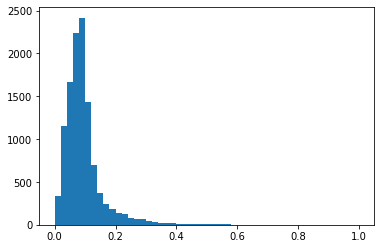

In [8]:
plt.hist(y,bins=50)

In [35]:
# Grid searching, link 1 is taken as example, and other links inherit parameter values from link 1
para_units=[4,8,16,32,50,64,80,100,128]
train_loss = []
validation_loss =[]
for j in para_units:
    model = keras.Sequential()

    model.add(keras.layers.LSTM(
        units=j,
        input_shape=(X_train.shape[1], X_train.shape[2]),activation='linear'
    ))

    model.add(keras.layers.Dense(units=1,activation='linear'))
    model.compile(
        loss='mean_absolute_error',   # MSE error is used as the loss function in this regression task
        # We use the Adam optimizer to optimise the loss function for parameter training, 0.001 is the learning rate
        optimizer=keras.optimizers.Adam(0.001)  
    )
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_split=0.1,
        verbose=1,
        shuffle=False
    )
    train_loss.append(history.history['loss'])
    validation_loss.append(history.history['val_loss'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 4752 samples, validate on 528 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
4752/4752 [==============================] - 2s 437us/sample - loss: 0.0753 - val_loss: 0.0446
Epoch 2/50
4752/4752 [==============================] - 1s 152us/sample - loss: 0.0587 - val_loss: 0.0434
Epoch 3/50
4752/4752 [==============================] - 1s 158us/sample - loss: 0.0567 - val_loss: 0.0424
Epoch 4/50
4752/4752 [==============================] - 1s 152us/sample - loss: 0.0549 - val_loss: 0.0419
Epoch 5/50
4752/4752 [==============================] - 1s 157us/sample - loss: 0.0535 - val_loss: 0.0416
Epoch 6/50
4752/4752 [==============================] - 1s 159us/sample - loss: 0.0522 - val_loss: 0.0415
Epoch 7/50
4752/4752 [==============================] - 1s 157us/sample - loss: 0.0512 - val_loss: 0.0415

4752/4752 [==============================] - 1s 171us/sample - loss: 0.0466 - val_loss: 0.0399
Epoch 47/50
4752/4752 [==============================] - 1s 171us/sample - loss: 0.0465 - val_loss: 0.0399
Epoch 48/50
4752/4752 [==============================] - 1s 169us/sample - loss: 0.0465 - val_loss: 0.0398
Epoch 49/50
4752/4752 [==============================] - 1s 170us/sample - loss: 0.0465 - val_loss: 0.0398
Epoch 50/50
4752/4752 [==============================] - 1s 170us/sample - loss: 0.0464 - val_loss: 0.0398
Train on 4752 samples, validate on 528 samples
Epoch 1/50
4752/4752 [==============================] - 1s 303us/sample - loss: 0.0576 - val_loss: 0.0442
Epoch 2/50
4752/4752 [==============================] - 1s 171us/sample - loss: 0.0525 - val_loss: 0.0428
Epoch 3/50
4752/4752 [==============================] - 1s 177us/sample - loss: 0.0511 - val_loss: 0.0421
Epoch 4/50
4752/4752 [==============================] - 1s 177us/sample - loss: 0.0503 - val_loss: 0.0415
Epoch 

Epoch 22/50
4752/4752 [==============================] - 1s 193us/sample - loss: 0.0471 - val_loss: 0.0402
Epoch 23/50
4752/4752 [==============================] - 1s 191us/sample - loss: 0.0471 - val_loss: 0.0401
Epoch 24/50
4752/4752 [==============================] - 1s 192us/sample - loss: 0.0471 - val_loss: 0.0401
Epoch 25/50
4752/4752 [==============================] - 1s 192us/sample - loss: 0.0471 - val_loss: 0.0401
Epoch 26/50
4752/4752 [==============================] - 1s 194us/sample - loss: 0.0470 - val_loss: 0.0401
Epoch 27/50
4752/4752 [==============================] - 1s 192us/sample - loss: 0.0470 - val_loss: 0.0400
Epoch 28/50
4752/4752 [==============================] - 1s 193us/sample - loss: 0.0469 - val_loss: 0.0400
Epoch 29/50
4752/4752 [==============================] - 1s 191us/sample - loss: 0.0469 - val_loss: 0.0400
Epoch 30/50
4752/4752 [==============================] - 1s 191us/sample - loss: 0.0469 - val_loss: 0.0400
Epoch 31/50
4752/4752 [==============

Epoch 24/50
4752/4752 [==============================] - 1s 252us/sample - loss: 0.0472 - val_loss: 0.0401
Epoch 25/50
4752/4752 [==============================] - 1s 251us/sample - loss: 0.0471 - val_loss: 0.0400
Epoch 26/50
4752/4752 [==============================] - 1s 251us/sample - loss: 0.0471 - val_loss: 0.0400
Epoch 27/50
4752/4752 [==============================] - 1s 252us/sample - loss: 0.0471 - val_loss: 0.0400
Epoch 28/50
4752/4752 [==============================] - 1s 250us/sample - loss: 0.0470 - val_loss: 0.0400
Epoch 29/50
4752/4752 [==============================] - 1s 249us/sample - loss: 0.0470 - val_loss: 0.0399
Epoch 30/50
4752/4752 [==============================] - 1s 253us/sample - loss: 0.0469 - val_loss: 0.0400
Epoch 31/50
4752/4752 [==============================] - 1s 250us/sample - loss: 0.0469 - val_loss: 0.0399
Epoch 32/50
4752/4752 [==============================] - 1s 250us/sample - loss: 0.0469 - val_loss: 0.0398
Epoch 33/50
4752/4752 [==============

In [36]:
train_loss=np.array(train_loss)
validation_loss=np.array(validation_loss)

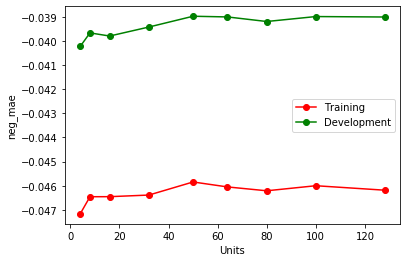

In [37]:
units_train=-train_loss[:,-1]
units_test=-validation_loss[:,-1]

plt.plot(para_units,units_train,'o-',color = 'r',label = 'Training')
plt.plot(para_units,units_test,'o-',color = 'g',label = 'Development')
plt.legend(loc='best')
param_name='Units'
plt.xlabel(param_name)
plt.ylabel('neg_mae')
plt.savefig('LSTM1.jpg',bbox_inches = 'tight')
plt.show()

In [21]:
from tensorflow.keras import backend as K

def lossfunction2(y_true, y_pred):
    RSS=K.sum(K.square((y_true- y_pred)))
    TSS=K.sum(K.square(K.mean(y_true, axis=-1)-y_true))
    return RSS/TSS

def lossfunction(y_true, y_pred):
    return (K.mean(K.square(y_pred[y_true>0.2] - y_true[y_true>0.2]), axis=-1)+K.mean(K.abs(y_pred[y_true<0.2] - y_true[y_true<0.2]), axis=-1))

In [16]:
model_start_timer = timer()

model = keras.Sequential()

model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2]),activation='linear'
))

model.add(keras.layers.Dense(units=1,activation='linear'))
model.compile(
    loss='mean_absolute_error',   # MSE error is used as the loss function in this regression task
    # We use the Adam optimizer to optimise the loss function for parameter training, 0.001 is the learning rate
    optimizer=keras.optimizers.Adam(0.001)  
)


history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)
train_loss=history.history['loss']
validation_loss=history.history['val_loss']
address='power_PassivhausLSTM.h5'
model.save(address)
model_end_timer = timer()    

#8/0.001/128/50
#64/0.001/128/50
#64/0.0001/128/100

#64/0.001/100/64
#128/0.0001/100/64
#32/0.0001/100/32，shuffle=True

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 4752 samples, validate on 528 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/150
4752/4752 [==============================] - 2s 503us/sample - loss: 0.0548 - val_loss: 0.0424
Epoch 2/150
4752/4752 [==============================] - 1s 203us/sample - loss: 0.0512 - val_loss: 0.0422
Epoch 3/150
4752/4752 [==============================] - 1s 202us/sample - loss: 0.0501 - val_loss: 0.0415
Epoch 4/150
4752/4752 [==============================] - 1s 200us/sample - loss: 0.0494 - val_loss: 0.0408
Epoch 5/150
4752/4752 [==============================] - 1s 183us/sample - loss: 0.0488 - val_loss: 0.0407
Epoch 6/150
4752/4752 [==============================] - 1s 180us/sample - loss: 0.0484 - val_loss: 0.0406
Epoch 7/150
4752/4752 [==============================] - 1s 186us/sample - loss: 0.0482 - val_loss:

4752/4752 [==============================] - 1s 197us/sample - loss: 0.0446 - val_loss: 0.0384
Epoch 146/150
4752/4752 [==============================] - 1s 199us/sample - loss: 0.0446 - val_loss: 0.0382
Epoch 147/150
4752/4752 [==============================] - 1s 200us/sample - loss: 0.0447 - val_loss: 0.0383
Epoch 148/150
4752/4752 [==============================] - 1s 212us/sample - loss: 0.0446 - val_loss: 0.0383
Epoch 149/150
4752/4752 [==============================] - 1s 204us/sample - loss: 0.0447 - val_loss: 0.0382
Epoch 150/150
4752/4752 [==============================] - 1s 199us/sample - loss: 0.0446 - val_loss: 0.0384


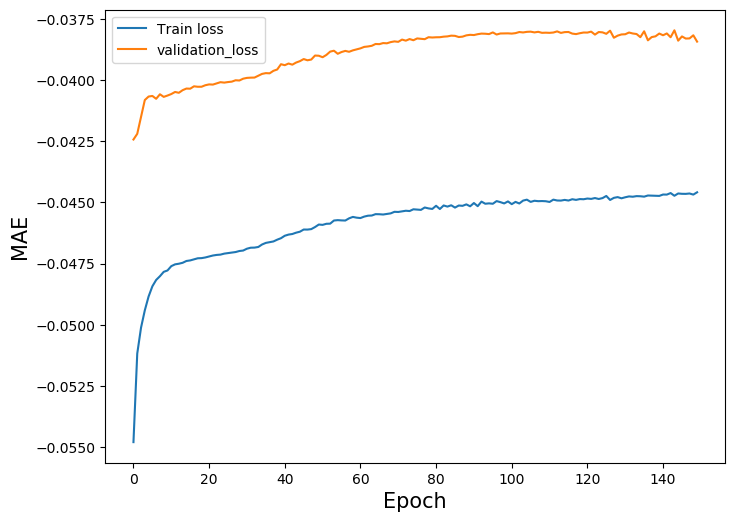

In [22]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(np.negative(train_loss), label='Train loss')
plt.plot(np.negative(validation_loss), label='validation_loss')
plt.legend()
plt.ylabel('MAE',fontsize=15)
plt.xlabel('Epoch',fontsize=15)
plt.savefig('LSTM2.jpg',bbox_inches = 'tight')

In [79]:
y_predLSTM = model.predict(X_test)
y_predLSTM=np.array(y_predLSTM).reshape(-1,1)

y_testback=scaler.inverse_transform(y_test).reshape(-1)
y_predLSTM=scaler.inverse_transform(y_predLSTM).reshape(-1)
print(model_end_timer-model_start_timer)

142.00650880000012


In [66]:
y_trainback=scaler.inverse_transform(y_train).reshape(-1)

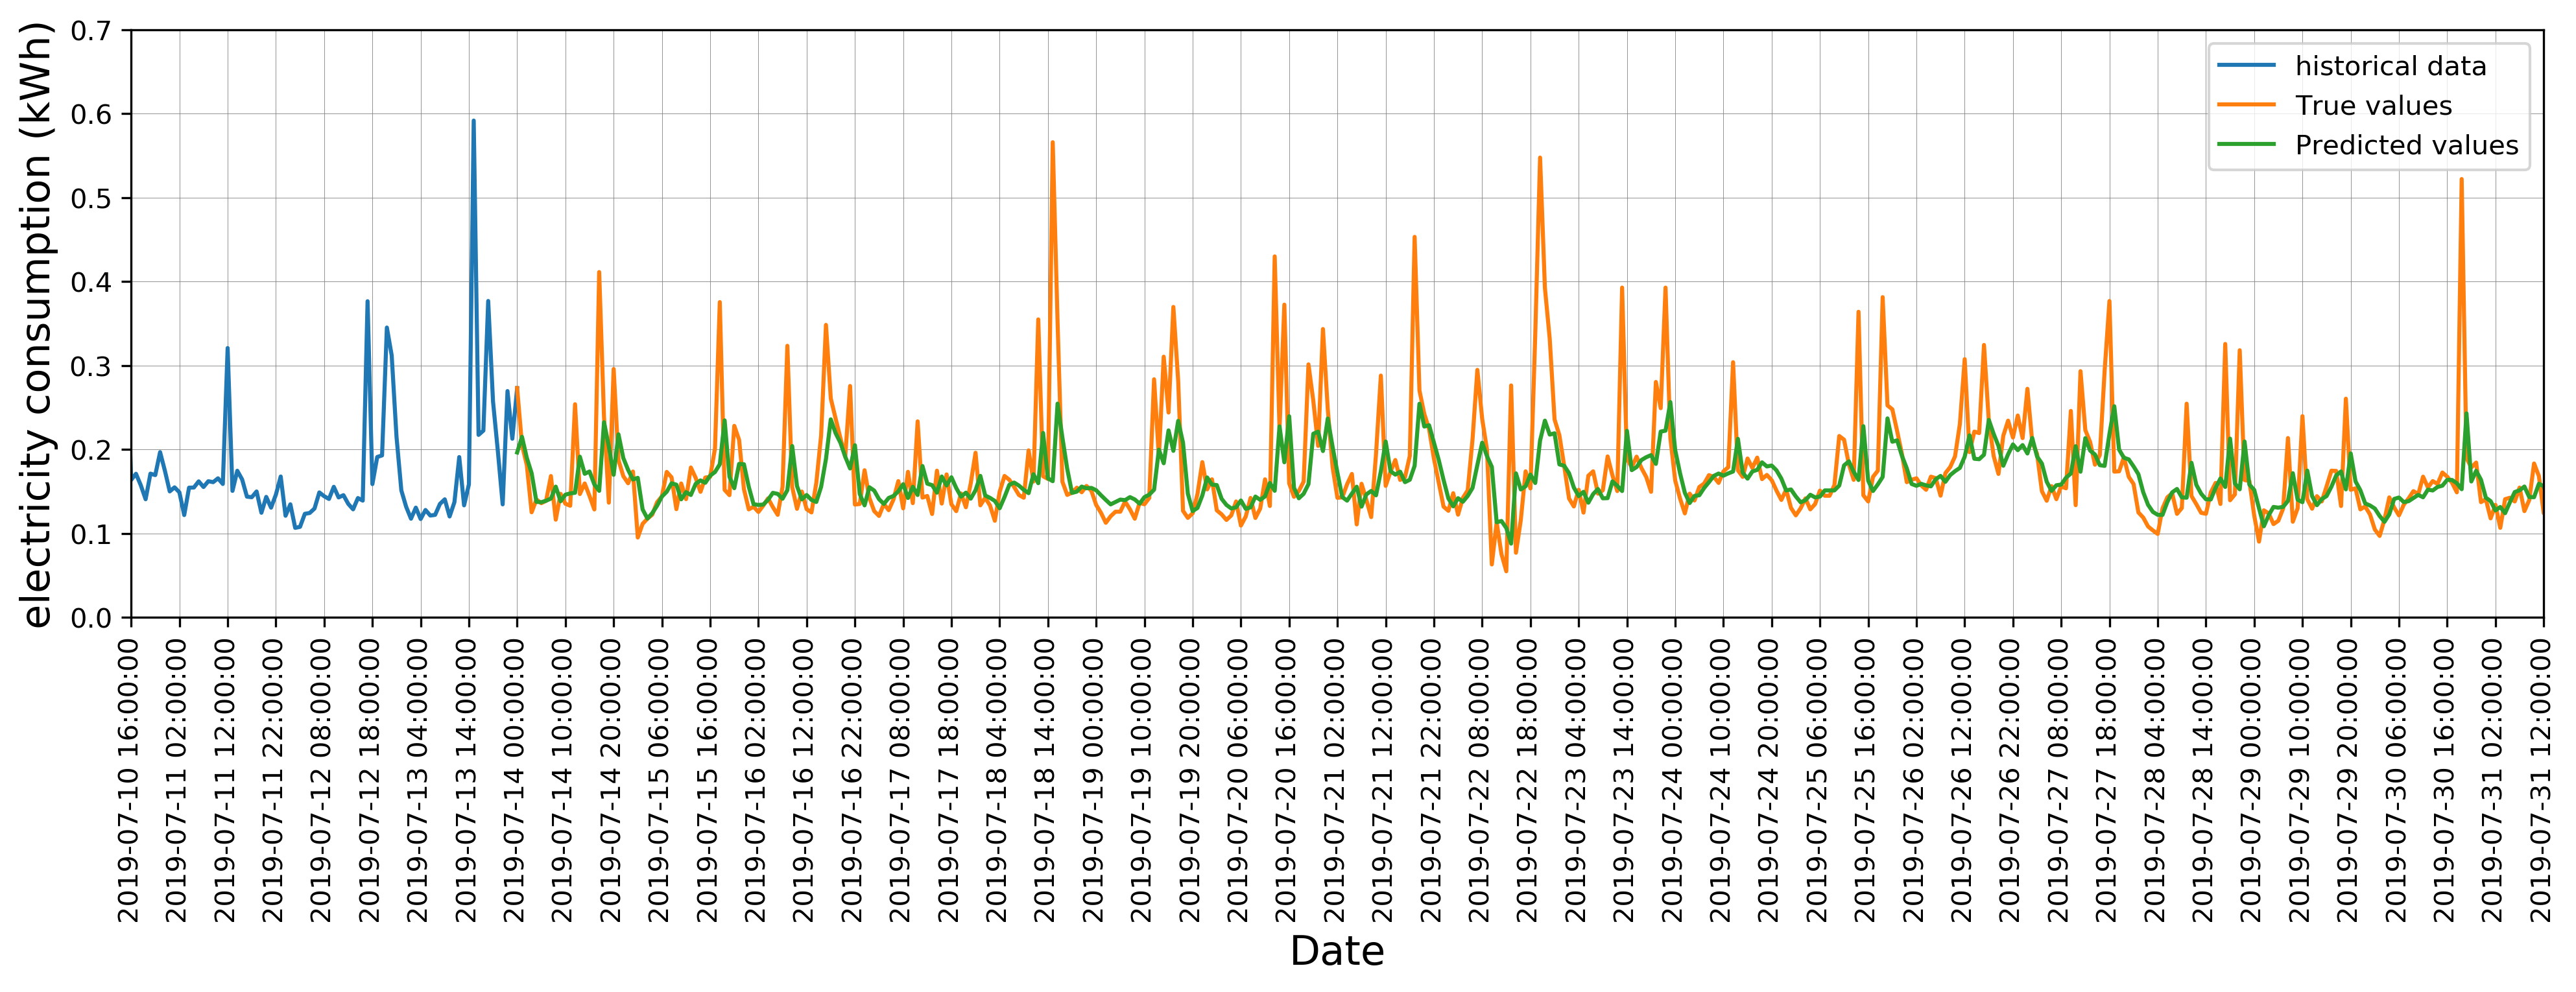

In [67]:
y_trainback=np.append(y_trainback,y_testback[0])

plt.figure(figsize=(16, 4), dpi=300)

plt.plot(y_trainback, label='historical data')
plt.plot(list(range(len(y_trainback)-1,len(y_trainback)+len(y_testback)-1)),y_testback,label='True values')
plt.grid(color='gray', linestyle='-', linewidth=0.2)
plt.plot(list(range(len(y_trainback)-1,len(y_trainback)+len(y_testback)-1)),y_predLSTM,label='Predicted values')

tick_positions = np.arange(0, len(power_Passivhaus),10)
tick_labels = power_Passivhaus.index[tick_positions]
plt.xticks(ticks = tick_positions,labels = tick_labels,rotation=90)
plt.xlim(5200,5700)
plt.ylim(0,0.7)
plt.legend()
plt.ylabel('electricity consumption (kWh)',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.savefig('LSTM_result.jpg',bbox_inches = 'tight')


In [80]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_testback,y_predLSTM)

0.031145543512474803

In [46]:
from sklearn.metrics import r2_score
r2_score(y_testback,y_predLSTM)

0.1529393780639685

In [82]:
y_testback2=y_testback[y_testback!=0]
y_predLSTM=y_predLSTM[y_testback!=0]

In [83]:
def MAPE(y_pred,y_true):
    y_true_reshape=y_true.reshape(y_pred.shape)
    mape = np.mean(np.abs(y_true_reshape - y_pred)/y_true_reshape*100)
    return mape

MAPE(y_predLSTM,y_testback2)

22.350064971972163

## RF

In [8]:
X_trainRF=X_train.reshape(-1,24)
X_testRF=X_test.reshape(-1,24)
y_trainRF=y_train.reshape(-1)

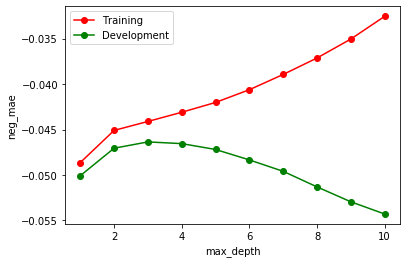

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve,validation_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=2) # cross-validation
param_range = [1,2,3,4,5,6,7,8,9,10]
param_name='max_depth'
# Average accuracy is the performance measurement
train_score,dev_score = validation_curve(DecisionTreeRegressor(criterion='mae'),X_trainRF,y_trainRF,param_name=param_name,param_range=param_range,cv=cv,scoring='neg_mean_absolute_error')
train_score =  np.mean(train_score,axis=1)
dev_score = np.mean(dev_score,axis=1)
plt.plot(param_range,train_score,'o-',color = 'r',label = 'Training')
plt.plot(param_range,dev_score,'o-',color = 'g',label = 'Development')
plt.legend(loc='best')
plt.xlabel(param_name)
plt.ylabel('neg_mae')
plt.savefig('RF1.jpg',bbox_inches = 'tight')
plt.show()

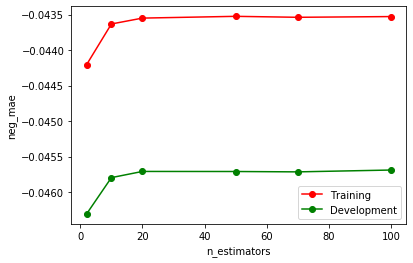

In [11]:

param_range = [2,10,20,50,70,100]
param_name='n_estimators'
# Average accuracy is the performance measurement
train_score,dev_score = validation_curve(RandomForestRegressor(n_jobs=6,criterion='mae',max_depth=3),X_trainRF,y_trainRF,param_name=param_name,param_range=param_range,cv=cv,scoring='neg_mean_absolute_error')
train_score =  np.mean(train_score,axis=1)
dev_score = np.mean(dev_score,axis=1)
plt.plot(param_range,train_score,'o-',color = 'r',label = 'Training')
plt.plot(param_range,dev_score,'o-',color = 'g',label = 'Development')
plt.legend(loc='best')
plt.xlabel(param_name)
plt.ylabel('neg_mae')
plt.savefig('RF2.jpg',bbox_inches = 'tight')
plt.show()

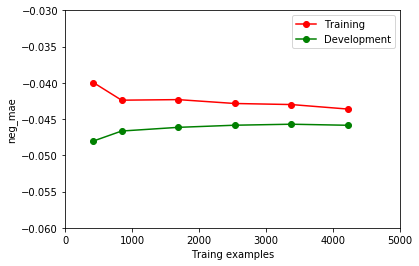

In [12]:
clf_RF=RandomForestRegressor(criterion='mae',n_estimators=20,n_jobs=6,max_depth=3)
train_sizes,train_score,dev_score = learning_curve(clf_RF,X_trainRF, y_trainRF,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=cv,scoring='neg_mean_absolute_error')
train_acc = np.mean(train_score,axis=1)
dev_acc = np.mean(dev_score,axis=1)
plt.plot(train_sizes,train_acc,'o-',color = 'r',label = 'Training')
plt.plot(train_sizes,dev_acc,'o-',color = 'g',label = 'Development')
plt.legend(loc='best')
plt.axis([0,5000,-0.06,-0.03])
plt.xlabel('Traing examples')
plt.ylabel('neg_mae')
plt.savefig('RF3.jpg',bbox_inches = 'tight')
plt.show()

In [49]:
from sklearn.ensemble import RandomForestRegressor

model_start_timer = timer()

clf_RF=RandomForestRegressor(criterion='mae',n_estimators=20,n_jobs=6,max_depth=3)
clf_RF.fit(X_trainRF, y_trainRF)
y_predRF=clf_RF.predict(X_testRF)
y_predRF=y_predRF.reshape(-1,1)
y_predRF=scaler.inverse_transform(y_predRF).reshape(-1)
y_testback=scaler.inverse_transform(y_test).reshape(-1)
model_end_timer = timer()    

print(model_end_timer -model_start_timer)

5.253725000000031


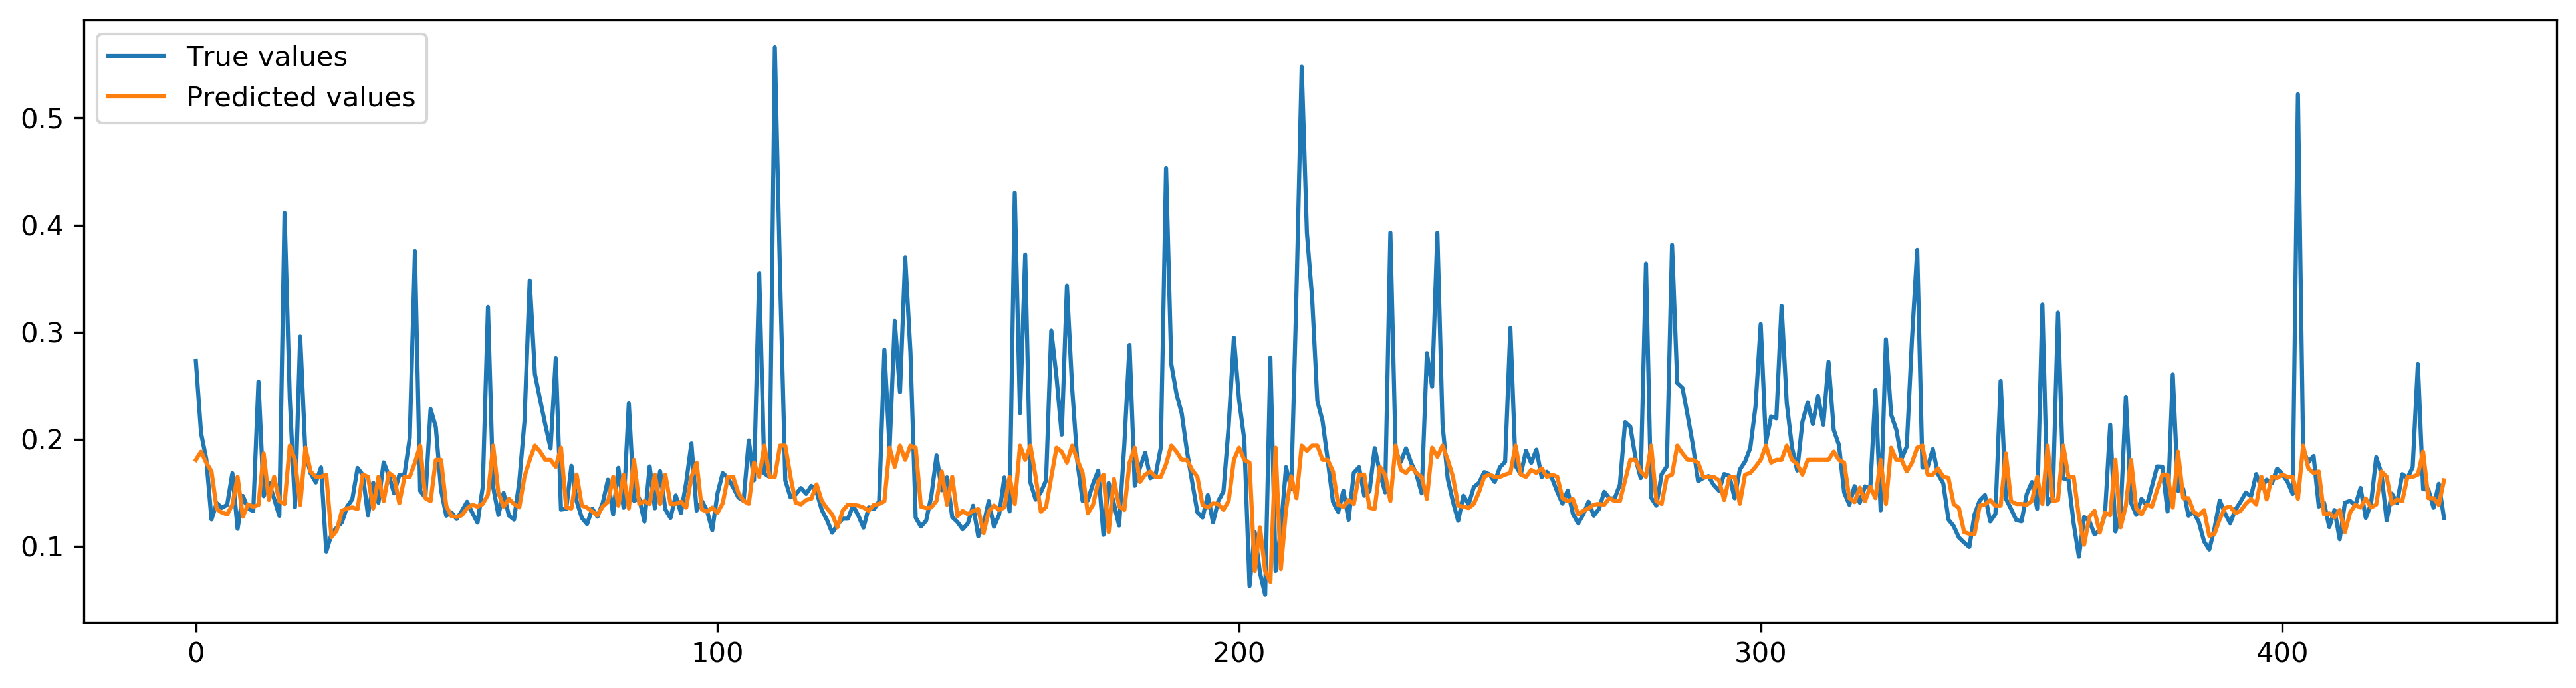

In [50]:
plt.figure(figsize=(16, 4), dpi=300)
#plt.plot(y_train, label='historical data')
plt.plot (y_testback, label='True values')
plt.plot( y_predRF, label='Predicted values')
plt.savefig('RF_result.jpg',bbox_inches = 'tight')
plt.legend()

In [51]:
mean_absolute_error(y_testback,y_predRF)

0.03722279442895884

In [54]:
MAPE(y_predRF,y_testback)

17.488343420140552

# XGBoost

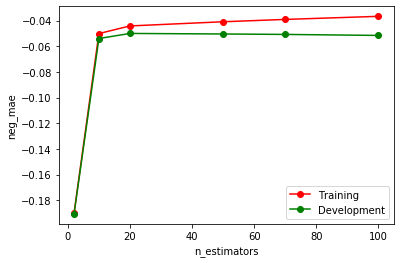

In [14]:
import xgboost as xgb

param_range = [2,10,20,50,70,100]
param_name='n_estimators'
# MAE is the performance measurement
train_score,dev_score = validation_curve(xgb.XGBRegressor(n_jobs=6,max_depth=3,eval_metric='mae'),X_trainRF,y_trainRF,param_name=param_name,param_range=param_range,cv=cv,scoring='neg_mean_absolute_error')
train_score =  np.mean(train_score,axis=1)
dev_score = np.mean(dev_score,axis=1)
plt.plot(param_range,train_score,'o-',color = 'r',label = 'Training')
plt.plot(param_range,dev_score,'o-',color = 'g',label = 'Development')
plt.legend(loc='best')
plt.xlabel(param_name)
plt.ylabel('neg_mae')
plt.savefig('XG1.jpg',bbox_inches = 'tight')
plt.show()

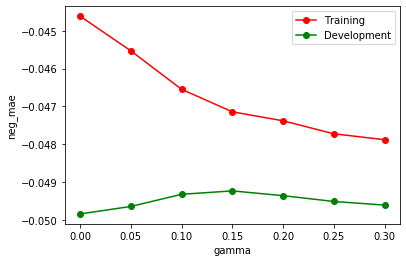

In [48]:
param_range = [0,0.05,0.1,0.15,0.2,0.25,0.3]
param_name='gamma'
# MAE is the performance measurement
train_score,dev_score = validation_curve(xgb.XGBRegressor(n_jobs=6,eval_metric='mae',max_depth=3,n_estimators=20,reg_lambda=9),X_trainRF,y_trainRF,param_name=param_name,param_range=param_range,cv=cv,scoring='neg_mean_absolute_error')
train_score =  np.mean(train_score,axis=1)
dev_score = np.mean(dev_score,axis=1)
plt.plot(param_range,train_score,'o-',color = 'r',label = 'Training')
plt.plot(param_range,dev_score,'o-',color = 'g',label = 'Development')
plt.legend(loc='best')
plt.xlabel(param_name)
plt.ylabel('neg_mae')
plt.savefig('XG2.jpg',bbox_inches = 'tight')
plt.show()

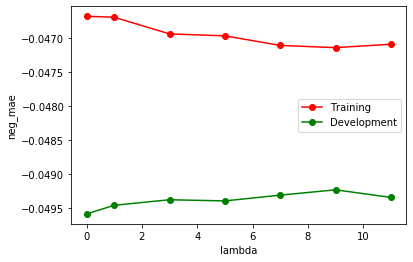

In [26]:
param_range = [0,1,3,5,7,9,11]
param_name='lambda'
# MAE is the performance measurement
train_score,dev_score = validation_curve(xgb.XGBRegressor(n_jobs=6,eval_metric='mae',max_depth=3,n_estimators=20,gamma=0.15),X_trainRF,y_trainRF,param_name=param_name,param_range=param_range,cv=cv,scoring='neg_mean_absolute_error')
train_score =  np.mean(train_score,axis=1)
dev_score = np.mean(dev_score,axis=1)
plt.plot(param_range,train_score,'o-',color = 'r',label = 'Training')
plt.plot(param_range,dev_score,'o-',color = 'g',label = 'Development')
plt.legend(loc='best')
plt.xlabel(param_name)
plt.ylabel('neg_mae')
plt.savefig('XG3.jpg',bbox_inches = 'tight')
plt.show()

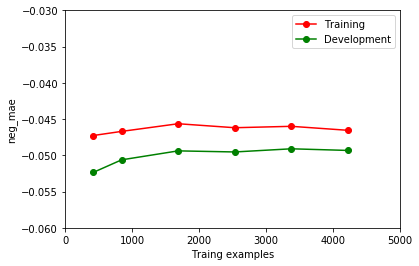

In [15]:
clf_boost=xgb.XGBRegressor(n_jobs=6,eval_metric='mae',max_depth=3,n_estimators=20,gamma=0.1,reg_lambda=9)
train_sizes,train_score,dev_score = learning_curve(clf_boost,X_trainRF, y_trainRF,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=cv,scoring='neg_mean_absolute_error')
train_acc = np.mean(train_score,axis=1)
dev_acc = np.mean(dev_score,axis=1)
plt.plot(train_sizes,train_acc,'o-',color = 'r',label = 'Training')
plt.plot(train_sizes,dev_acc,'o-',color = 'g',label = 'Development')
plt.legend(loc='best')
plt.axis([0,5000,-0.06,-0.03])
plt.xlabel('Traing examples')
plt.ylabel('neg_mae')
plt.savefig('XG4.jpg',bbox_inches = 'tight')
plt.show()

In [55]:
import xgboost as xgb

model_start_timer = timer()

clf_boost=xgb.XGBRegressor(n_jobs=6,eval_metric='mae',max_depth=3,n_estimators=20,gamma=0.15,reg_lambda=9)
clf_boost.fit(X_trainRF, y_trainRF)
y_predXG=clf_boost.predict(X_testRF)
y_predXG=y_predXG.reshape(-1,1)
y_predXG=scaler.inverse_transform(y_predXG).reshape(-1)

model_end_timer = timer()    
print(model_end_timer-model_start_timer)

0.06924719999960871


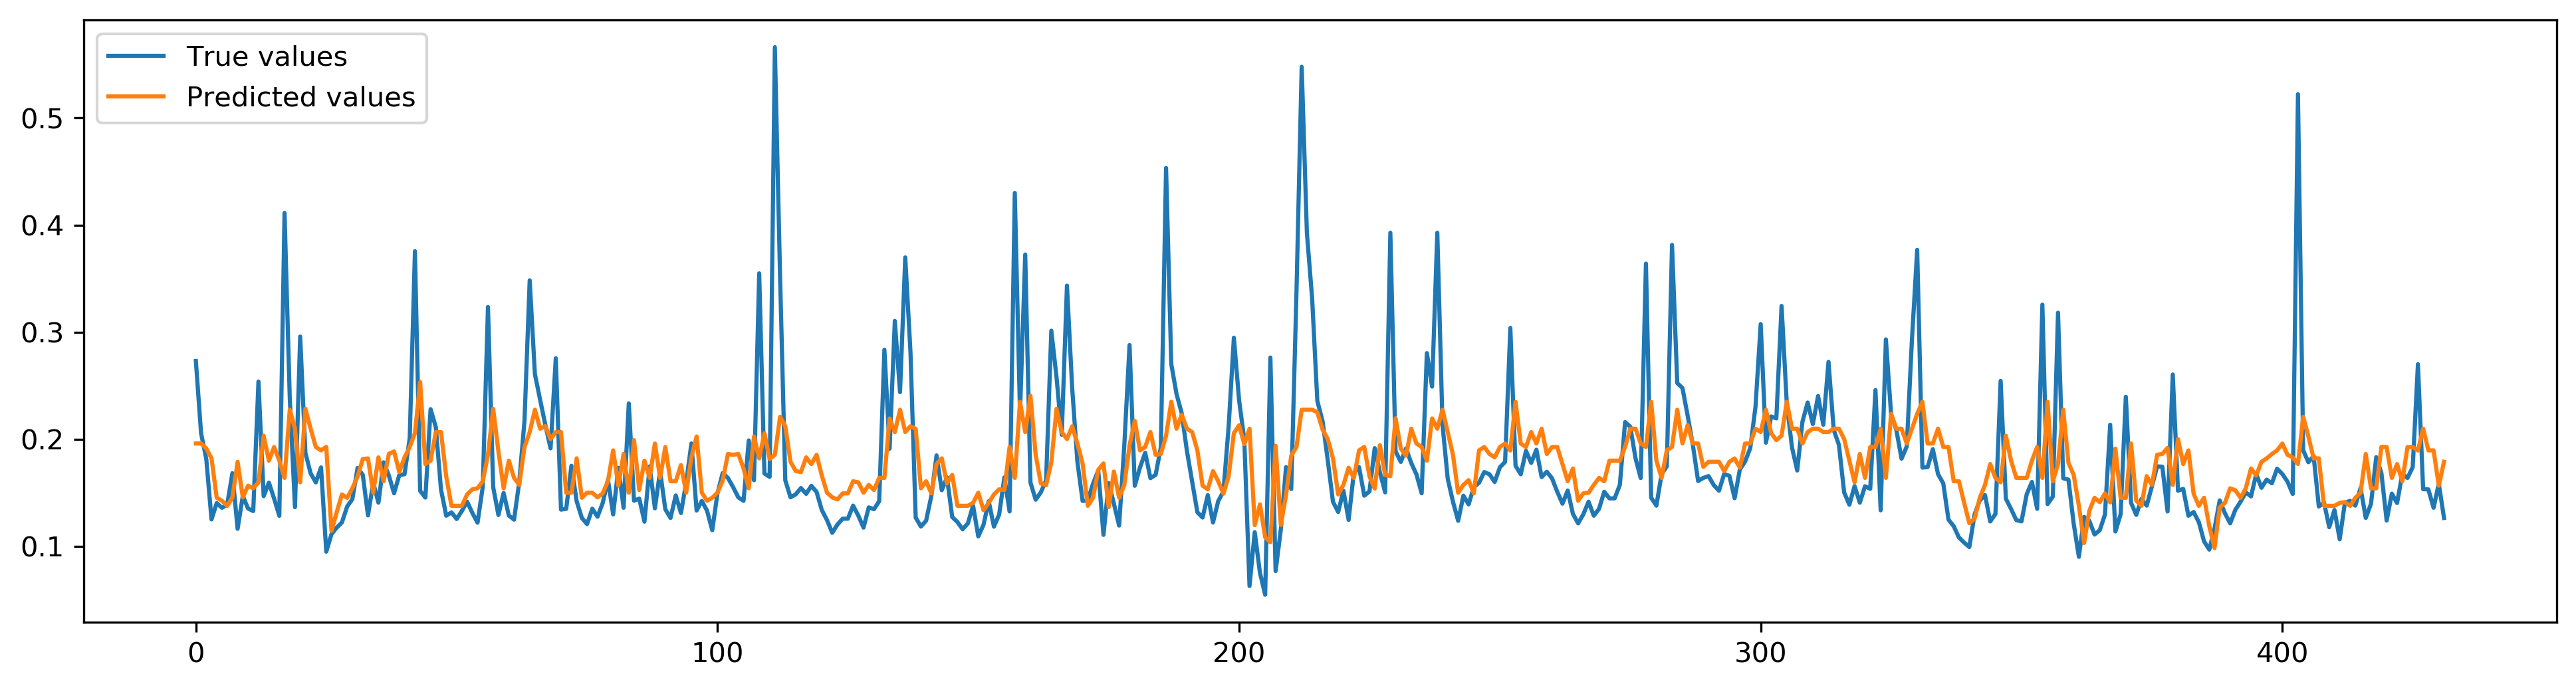

In [56]:
plt.figure(figsize=(16, 4), dpi=300)
#plt.plot(y_train, label='historical data')
plt.plot (y_testback, label='True values')
plt.plot( y_predXG, label='Predicted values')
plt.savefig('XG_result.jpg',bbox_inches = 'tight')
plt.legend()

In [57]:
mean_absolute_error(y_testback,y_predXG)

0.04044349480466935

# SVR

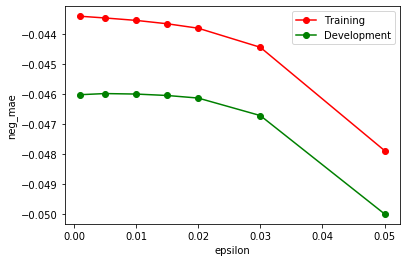

In [28]:
from sklearn.svm import SVR

param_range = [0.001,0.005,0.01,0.015,0.02,0.03,0.05]
param_name='epsilon'
# MAE is the performance measurement
train_score,dev_score = validation_curve(SVR(kernel='rbf',gamma='auto',C=7),X_trainRF,y_trainRF,param_name=param_name,param_range=param_range,cv=cv,scoring='neg_mean_absolute_error')
train_score =  np.mean(train_score,axis=1)
dev_score = np.mean(dev_score,axis=1)
plt.plot(param_range,train_score,'o-',color = 'r',label = 'Training')
plt.plot(param_range,dev_score,'o-',color = 'g',label = 'Development')
plt.legend(loc='best')
plt.xlabel(param_name)
plt.ylabel('neg_mae')
plt.savefig('SVR1.jpg',bbox_inches = 'tight')
plt.show()

#epsilon=0.01

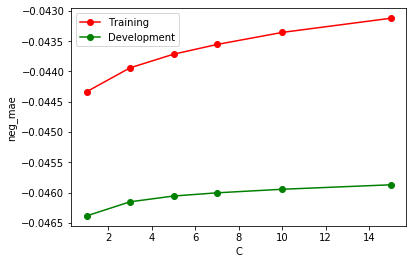

In [33]:
param_range = [1,3,5,7,10,15]
param_name='C'
# MAE is the performance measurement
train_score,dev_score = validation_curve(SVR(kernel='rbf',gamma='auto',epsilon=0.01),X_trainRF,y_trainRF,param_name=param_name,param_range=param_range,cv=cv,scoring='neg_mean_absolute_error')
train_score =  np.mean(train_score,axis=1)
dev_score = np.mean(dev_score,axis=1)
plt.plot(param_range,train_score,'o-',color = 'r',label = 'Training')
plt.plot(param_range,dev_score,'o-',color = 'g',label = 'Development')
plt.legend(loc='best')
plt.xlabel(param_name)
plt.ylabel('neg_mae')
plt.savefig('SVR2.jpg',bbox_inches = 'tight')
plt.show()

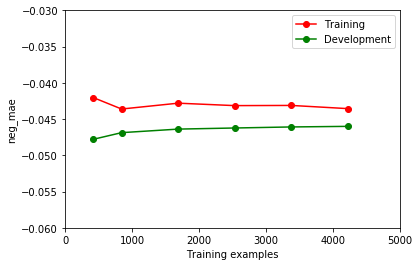

In [34]:
from sklearn.svm import SVR

clf_SVM=SVR(C=7,kernel='rbf',gamma='auto',epsilon=0.01)

train_sizes,train_score,dev_score = learning_curve(clf_SVM,X_trainRF, y_trainRF,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=cv,scoring='neg_mean_absolute_error')
train_acc = np.mean(train_score,axis=1)
dev_acc = np.mean(dev_score,axis=1)
plt.plot(train_sizes,train_acc,'o-',color = 'r',label = 'Training')
plt.plot(train_sizes,dev_acc,'o-',color = 'g',label = 'Development')
plt.legend(loc='best')
plt.axis([0,5000,-0.06,-0.03])
plt.xlabel('Training examples')
plt.ylabel('neg_mae')
plt.savefig('SVR3.jpg',bbox_inches = 'tight')
plt.show()

In [59]:
from sklearn.svm import SVR

clf_SVM=SVR(C=7,kernel='rbf',gamma='auto',epsilon=0.01)

model_start_timer= timer()    
clf_SVM.fit(X_trainRF, y_trainRF)
y_predSVM=clf_SVM.predict(X_testRF)
y_predSVM=y_predSVM.reshape(-1,1)
y_predSVM=scaler.inverse_transform(y_predSVM).reshape(-1)
y_testback=scaler.inverse_transform(y_test).reshape(-1)

model_end_timer = timer()    
print(model_end_timer-model_start_timer)

1.2528124999998909


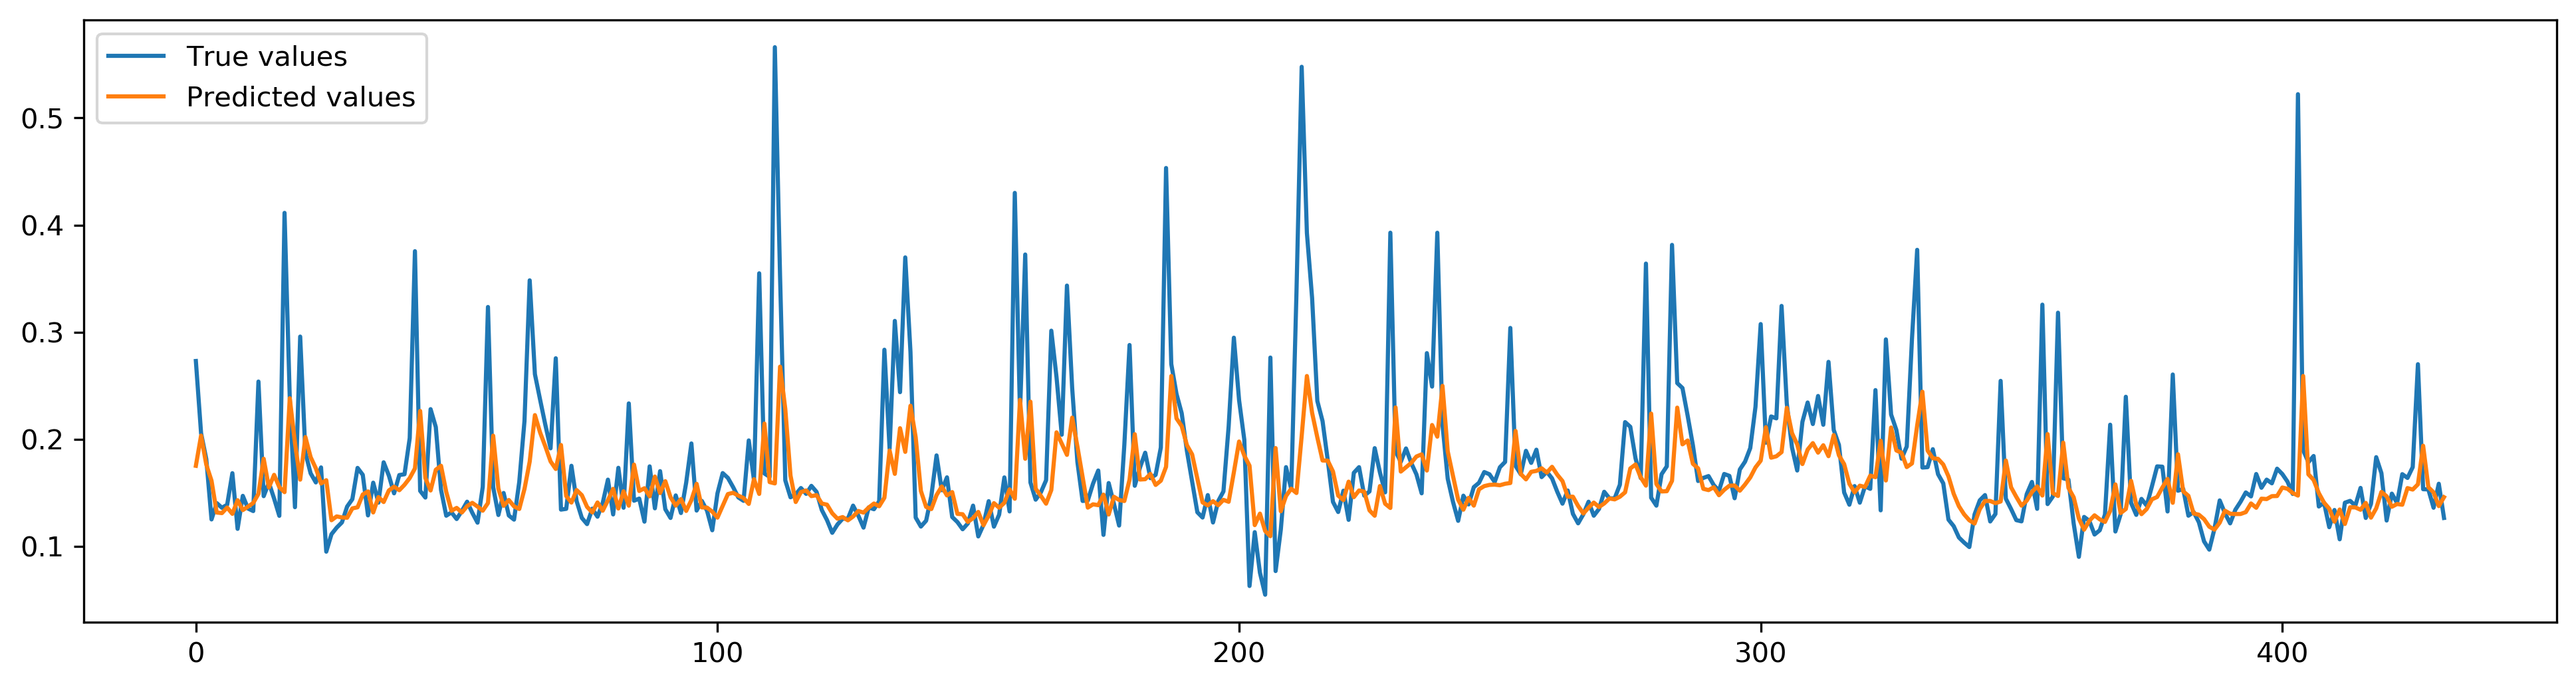

In [60]:
plt.figure(figsize=(16, 4), dpi=300)
#plt.plot(y_train, label='historical data')
plt.plot (y_testback, label='True values')
plt.plot( y_predSVM, label='Predicted values')
plt.savefig('SVM_result.jpg',bbox_inches = 'tight')
plt.legend()

In [61]:
mean_absolute_error(y_testback,y_predSVM)

0.03629643650999425

# Comparision

In [72]:
# transform back to original data range
y_trainback=scaler.inverse_transform(y_train).reshape(-1)

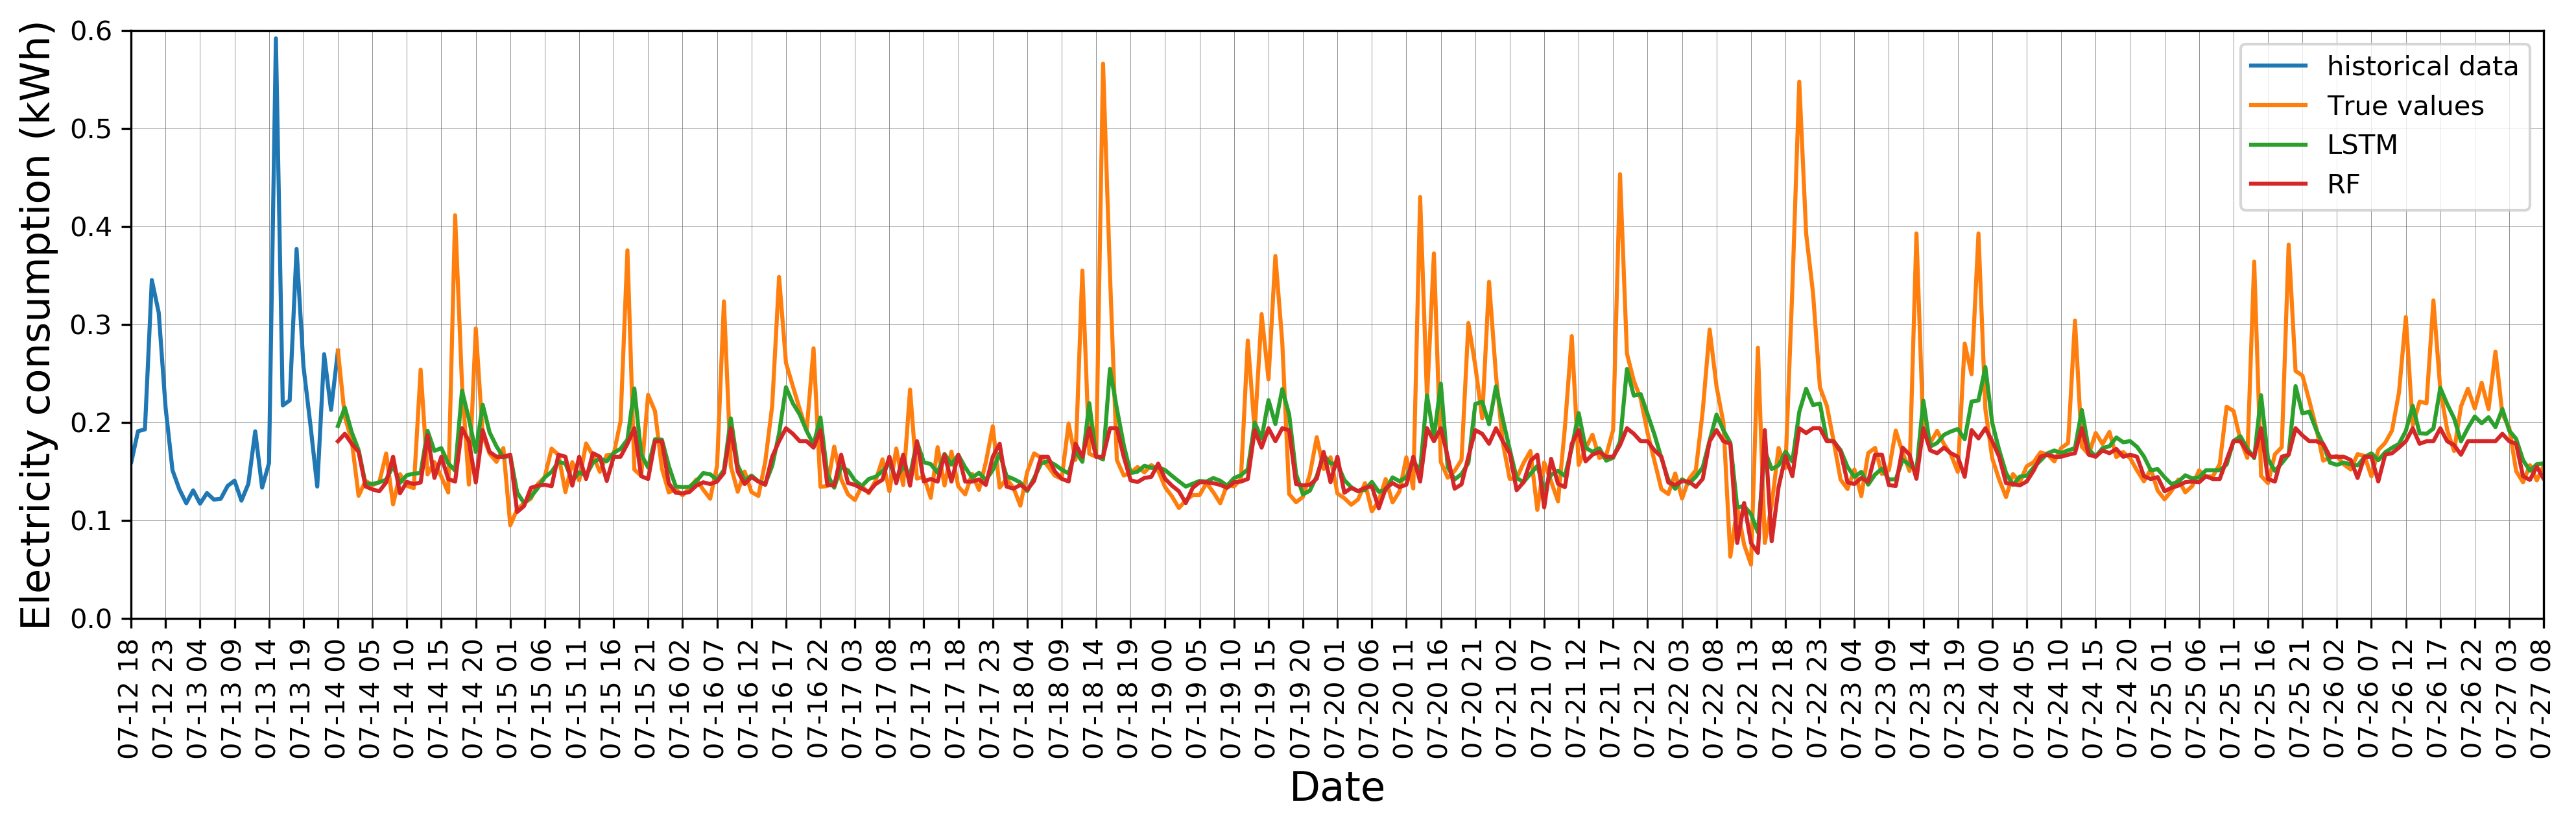

In [71]:
# LSTM and RF
y_trainback=np.append(y_trainback,y_testback[0])

plt.figure(figsize=(16, 4), dpi=300)

plt.plot(y_trainback, label='historical data')
plt.plot(list(range(len(y_trainback)-1,len(y_trainback)+len(y_testback)-1)),y_testback,label='True values')
plt.grid(color='gray', linestyle='-', linewidth=0.2)
plt.plot(list(range(len(y_trainback)-1,len(y_trainback)+len(y_testback)-1)),y_predLSTM,label='LSTM')
plt.plot(list(range(len(y_trainback)-1,len(y_trainback)+len(y_testback)-1)),y_predRF,label='RF')



tick_positions = np.arange(0, len(power_Passivhaus),5)
tick_labels = power_Passivhaus.index[tick_positions]
tick_labels=[datetime.strftime(x,'%m-%d %H') for x in tick_labels]
plt.xticks(ticks = tick_positions,labels = tick_labels,rotation=90,fontsize=10)
plt.xlim(5250,5600)
plt.ylim(0,0.6)
plt.legend()
plt.ylabel('Electricity consumption (kWh)',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.savefig('All1.jpg',bbox_inches = 'tight')

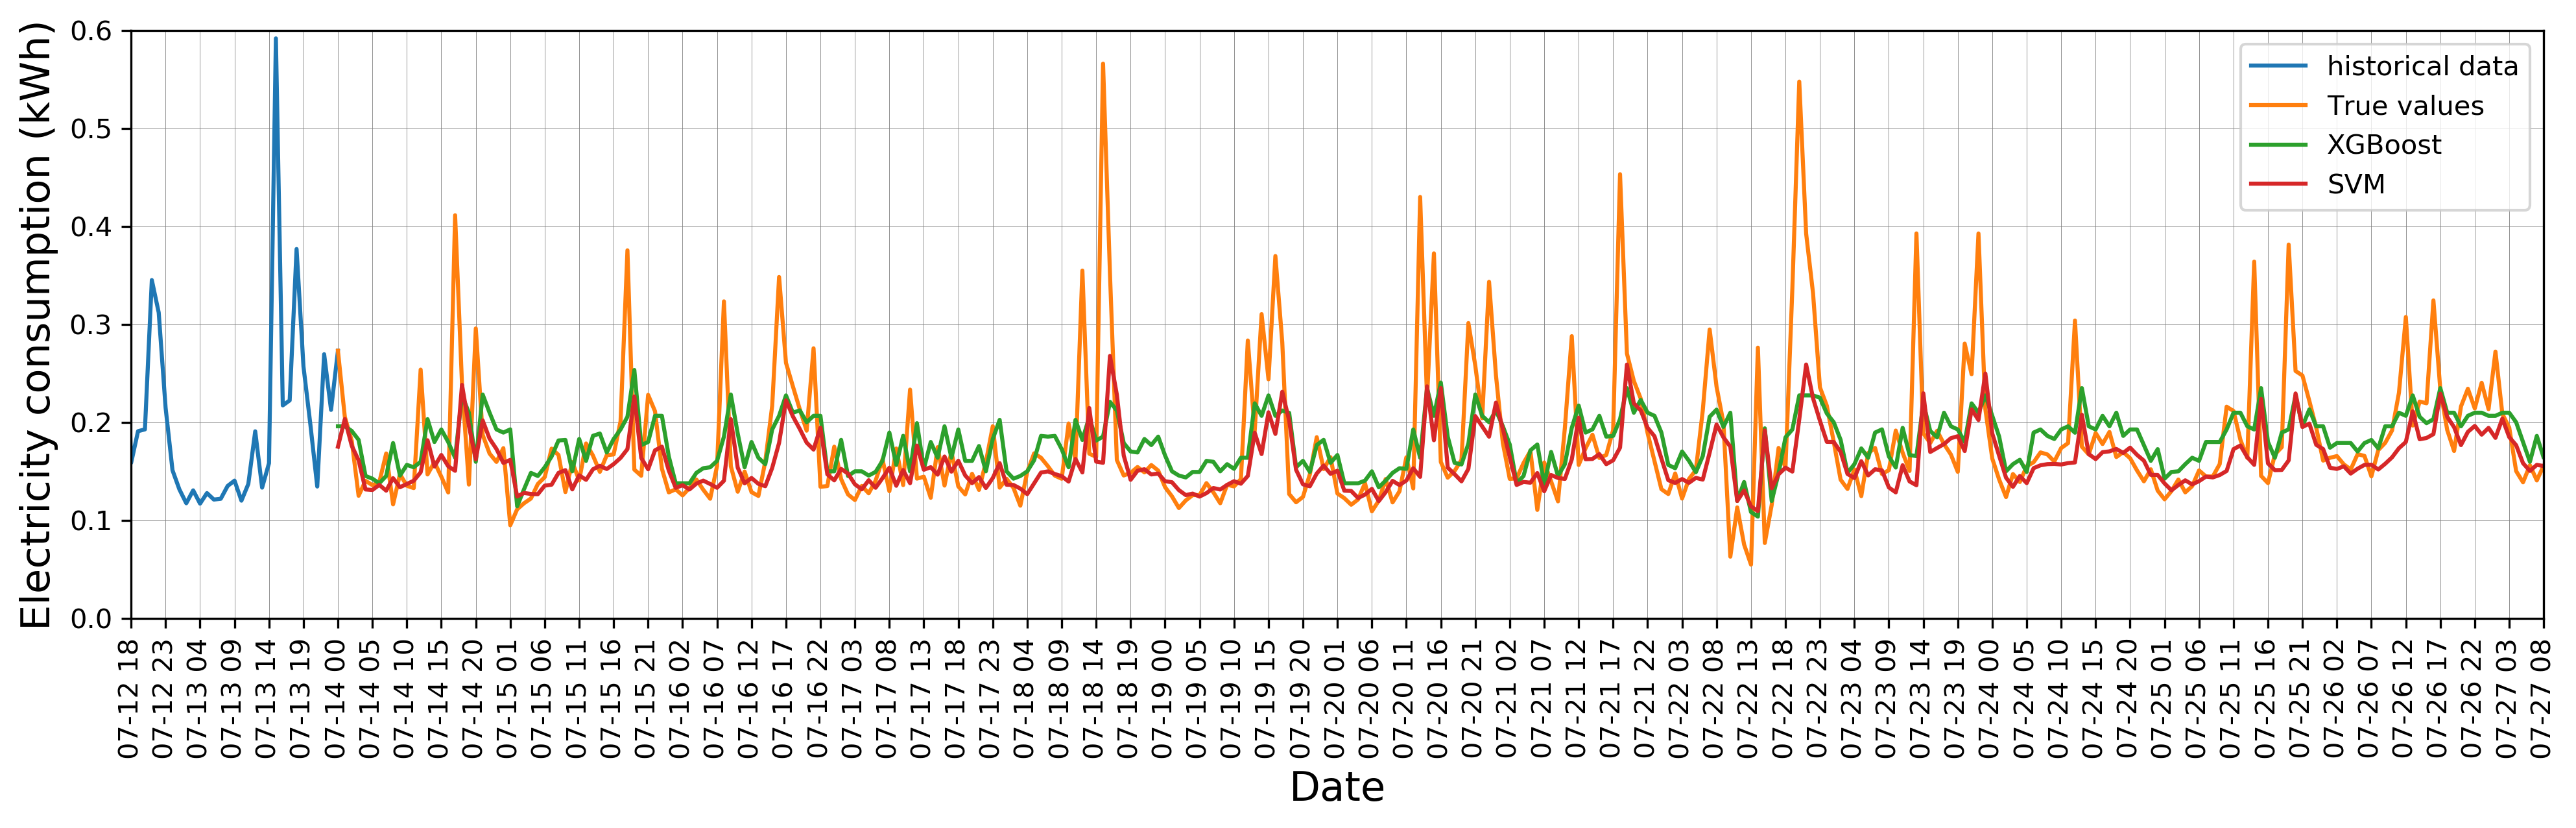

In [73]:
#SVM nad XGboost
y_trainback=np.append(y_trainback,y_testback[0])

plt.figure(figsize=(16, 4), dpi=300)

plt.plot(y_trainback, label='historical data')
plt.plot(list(range(len(y_trainback)-1,len(y_trainback)+len(y_testback)-1)),y_testback,label='True values')
plt.grid(color='gray', linestyle='-', linewidth=0.2)

plt.plot(list(range(len(y_trainback)-1,len(y_trainback)+len(y_testback)-1)),y_predXG,label='XGBoost')
plt.plot(list(range(len(y_trainback)-1,len(y_trainback)+len(y_testback)-1)),y_predSVM,label='SVM')


tick_positions = np.arange(0, len(power_Passivhaus),5)
tick_labels = power_Passivhaus.index[tick_positions]
tick_labels=[datetime.strftime(x,'%m-%d %H') for x in tick_labels]
plt.xticks(ticks = tick_positions,labels = tick_labels,rotation=90,fontsize=10)
plt.xlim(5250,5600)
plt.ylim(0,0.6)
plt.legend()
plt.ylabel('Electricity consumption (kWh)',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.savefig('All2.jpg',bbox_inches = 'tight')